### Import Libs

In [15]:
from pyspark.sql import SparkSession, functions as F, DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import types 
from pyspark.sql.functions import when
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
import pyspark.sql.types as T
from pyspark.sql.functions import desc
spark = SparkSession.builder.getOrCreate()

### Load Data

In [16]:
sprkdf_train = spark.read.csv('train.csv', inferSchema=True, header=True)
sprkdf_test = spark.read.csv('test.csv', inferSchema=True, header=True)
print("Shape of sprkdf_train",(sprkdf_train.count(), len(sprkdf_train.columns)))
print("Shape of sprkdf_test",(sprkdf_test.count(), len(sprkdf_test.columns)))

Shape of sprkdf_train (1460, 81)
Shape of sprkdf_test (1459, 80)


### Null Values

In [17]:
# Union df for transformation
sprkdf_test = sprkdf_test.withColumn('SalePrice', lit(-1))
sprkdf_concat = sprkdf_train.union(sprkdf_test)

# Count Null values
sprkdf_concat.select([F.count(F.when(F.isnan(i) | \
                                   F.col(i).contains('NA') | \
                                   F.col(i).contains('NULL') | \
                                   F.col(i).isNull(), i)).alias(i) \
                    for i in sprkdf_concat.columns]).show()


+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

### Drop Columns

In [18]:

Columns_to_drop = ['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']

sprkdf_concat = sprkdf_concat.drop(*Columns_to_drop)
# print("Shape of sprkdf_concat",(sprkdf_concat.count(), len(sprkdf_concat.columns)))

### FillNa & Converting

In [21]:
# MSSubClass as str
sprkdf_concat = sprkdf_concat.withColumn('MSSubClass', col('MSSubClass').cast('string'))

# MSZoning NA in pred. filling with most popular values
cnts = sprkdf_concat.groupBy("MSZoning").count().sort(desc("count"))
sprkdf_concat.groupBy("MSZoning").count().sort(desc("count")).show()
mode = cnts.select("MSZoning").limit(1).collect()[0][0]
sprkdf_concat = sprkdf_concat.withColumn("MSZoning", when(sprkdf_concat["MSZoning"] == 'NA', mode).otherwise(sprkdf_concat["MSZoning"]))
sprkdf_concat.groupBy("MSZoning").count().sort(desc("count")).show()

# LotFrontage  NA in all. I suppose NA means 0
# sprkdf_concat.groupBy("LotFrontage").count().sort(desc("count")).show()
mean_value = sprkdf_concat.select(_mean("LotFrontage").alias('mean')).collect()[0]['mean']
sprkdf_concat = sprkdf_concat.withColumn("LotFrontage", when(sprkdf_concat["LotFrontage"] == 'NA', mean_value).otherwise(sprkdf_concat["LotFrontage"]))
# sprkdf_concat.groupBy("LotFrontage").count().sort(desc("count")).show()

# Alley  NA in all. NA means no access
# features['Alley'] = features['Alley'].fillna('NOACCESS')
sprkdf_concat = sprkdf_concat.withColumn('Alley', when(sprkdf_concat['Alley'] == 'NA', 'NOACCESS').otherwise(sprkdf_concat['Alley']))

# Converting OverallCond to str
# sprkdf_concat.describe(["OverallCond"]).show()
from pyspark.sql.types import StructField,IntegerType, StructType,StringType
sprkdf_concat = sprkdf_concat.withColumn("OverallCond", col("OverallCond").cast(StringType()) )
# sprkdf_concat.describe(["OverallCond"]).show()
# sprkdf_concat.describe(["OverallCond", "MSZoning", 'MSSubClass'], ).show()
# sprkdf_concat.schema

# MasVnrType NA in all. filling with most popular values
# features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
cnts = sprkdf_concat.where(sprkdf_concat['MasVnrType'] != 'None').groupBy('MasVnrType').count().sort(desc("count"))
mode = cnts.select('MasVnrType').limit(1).collect()[0][0]
sprkdf_concat = sprkdf_concat.withColumn('MasVnrType', when(sprkdf_concat['MasVnrType'] == 'None', mode).otherwise(sprkdf_concat['MasVnrType']))



+--------+-----+
|MSZoning|count|
+--------+-----+
|      RL| 2269|
|      RM|  460|
|      FV|  139|
|      RH|   26|
| C (all)|   25|
+--------+-----+

+--------+-----+
|MSZoning|count|
+--------+-----+
|      RL| 2269|
|      RM|  460|
|      FV|  139|
|      RH|   26|
| C (all)|   25|
+--------+-----+



In [7]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col_name in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    sprkdf_concat = sprkdf_concat.withColumn(col_name, when(sprkdf_concat[col_name] == 'NA', 'NoBSMT').otherwise(sprkdf_concat[col_name]))

# TotalBsmtSF  NA in pred. I suppose NA means 0
sprkdf_concat = sprkdf_concat.withColumn('TotalBsmtSF', when(sprkdf_concat['TotalBsmtSF'] == 'NA', 0).otherwise(sprkdf_concat['TotalBsmtSF']))

# Electrical NA in pred. filling with most popular values
cnts = sprkdf_concat.where(sprkdf_concat['Electrical'] != 'None').groupBy('Electrical').count().sort(desc("count"))
mode = cnts.select('Electrical').limit(1).collect()[0][0]
sprkdf_concat = sprkdf_concat.withColumn('Electrical', when(sprkdf_concat['Electrical'] == 'NA', mode).otherwise(sprkdf_concat['Electrical']))

# KitchenAbvGr to categorical
sprkdf_concat = sprkdf_concat.withColumn('KitchenAbvGr', col('KitchenAbvGr').cast(StringType()) )

# KitchenQual NA in pred. filling with most popular values
# features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
cnts = sprkdf_concat.where(sprkdf_concat['KitchenQual'] != 'None').groupBy('KitchenQual').count().sort(desc("count"))
mode = cnts.select('KitchenQual').limit(1).collect()[0][0]
sprkdf_concat = sprkdf_concat.withColumn('KitchenQual', when(sprkdf_concat['KitchenQual'] == 'NA', mode).otherwise(sprkdf_concat['KitchenQual']))

# FireplaceQu  NA in all. NA means No Fireplace
# features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')
# sprkdf_concat.groupBy('FireplaceQu').count().sort(desc("count")).show()
# sprkdf_concat = sprkdf_concat.withColumn('KitchenQual', when(sprkdf_concat['KitchenQual'] == 'NA', mode).otherwise(sprkdf_concat['KitchenQual']))
sprkdf_concat = sprkdf_concat.drop('FireplaceQu')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col_name in ('GarageType', 'GarageFinish', 'GarageQual'):
    sprkdf_concat = sprkdf_concat.withColumn(col_name, when(sprkdf_concat[col_name] == 'NA', 'NoGRG').otherwise(sprkdf_concat[col_name]))

# GarageCars  NA in pred. I suppose NA means 0
sprkdf_concat = sprkdf_concat.withColumn('GarageCars', when(sprkdf_concat['GarageCars'] == 'NA', 0).otherwise(sprkdf_concat['GarageCars']))

# SaleType NA in pred. filling with most popular values
cnts = sprkdf_concat.where(sprkdf_concat['SaleType'] != 'None').groupBy('SaleType').count().sort(desc("count"))
mode = cnts.select('SaleType').limit(1).collect()[0][0]
sprkdf_concat = sprkdf_concat.withColumn('SaleType', when(sprkdf_concat['SaleType'] == 'NA', mode).otherwise(sprkdf_concat['SaleType']))

# Year and Month to categorical
sprkdf_concat = sprkdf_concat.withColumn('YrSold', col('YrSold').cast(StringType()) )
sprkdf_concat = sprkdf_concat.withColumn('MoSold', col('MoSold').cast(StringType()) )


sprkdf_concat = sprkdf_concat.withColumn('TotalSF', col('TotalBsmtSF')+col('1stFlrSF')+col('2ndFlrSF') )
sprkdf_concat = sprkdf_concat.drop('TotalBsmtSF', '1stFlrSF', '2ndFlrSF')

### Log Transformation

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+

+-------+-------------------+
|summary|          SalePrice|
+-------+-------------------+
|  count|               1460|
|   mean|  5.221978956475621|
| stddev|0.17347974217176848|
|    min|   4.54282542695918|
|    max|  5.877946951629188|
+-------+-------------------+



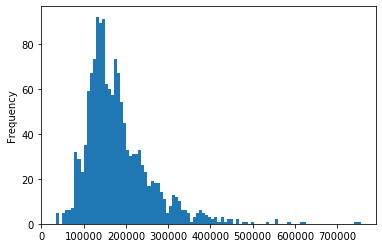

In [8]:
from pyspark.sql.functions import col

sprkdf_train = sprkdf_concat.where(col('SalePrice') != -1)

# Draw plot
pdf = sprkdf_train.toPandas()
pdf['SalePrice'].plot.hist(bins = 100)

sprkdf_train.describe(['SalePrice']).show()
sprkdf_train = sprkdf_train.withColumn('SalePrice', F.log(10.0, sprkdf_concat['SalePrice']))
sprkdf_train.describe(['SalePrice']).show()

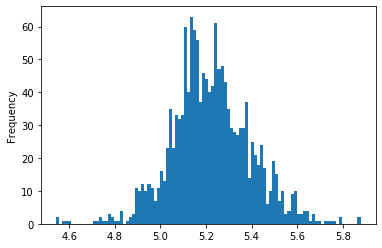

In [9]:
# Draw plot after log transformation
pdf2 = sprkdf_train.toPandas()
pdf2['SalePrice'].plot.hist(bins = 100)

### Converting Categorical Data to Dummies

In [10]:
categories = sprkdf_train.select('Condition1').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('Condition1') == category, 1).otherwise(0).alias('Condition1' + category)
         for category in categories]
sprkdf_train = sprkdf_train.select(exprs+sprkdf_train.columns)

categories = sprkdf_train.select('Condition2').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('Condition2') == category, 1).otherwise(0).alias('Condition2' + category)
         for category in categories]
sprkdf_train = sprkdf_train.select(exprs+sprkdf_train.columns)

categories = sprkdf_train.select('Exterior1st').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('Exterior1st') == category, 1).otherwise(0).alias('Exterior1st' + category)
         for category in categories]
sprkdf_train = sprkdf_train.select(exprs+sprkdf_train.columns)

categories = sprkdf_train.select('Exterior2nd').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('Exterior2nd') == category, 1).otherwise(0).alias('Exterior2nd' + category)
         for category in categories]
sprkdf_train = sprkdf_train.select(exprs+sprkdf_train.columns)

# categories = sprkdf_train.select('Exterior_nan').distinct().rdd.flatMap(lambda x: x).collect()
# exprs = [F.when(F.col('Exterior_nan') == category, 1).otherwise(0).alias('Exterior_nan' + category)
#          for category in categories]
# sprkdf_train = sprkdf_train.select(exprs+sprkdf_train.columns)



### Splitting Train and Test Features

In [11]:
sprkdf_train_split = sprkdf_train.randomSplit([0.7, 0.3])
print("Shape of sprkdf_train_split[0]",(sprkdf_train_split[0].count(), len(sprkdf_train_split[0].columns)))
print("Shape of sprkdf_train_split[1]",(sprkdf_train_split[1].count(), len(sprkdf_train_split[1].columns)))

train_x = sprkdf_train_split[0].drop('SalePrice')
train_y = sprkdf_train_split[1].select('SalePrice')
test_x = sprkdf_train_split[0].drop('SalePrice')
test_y = sprkdf_train_split[1].select('SalePrice')

print("Shape of train_x",(train_x.count(), len(train_x.columns)))
print("Shape of train_y",(train_y.count(), len(train_y.columns)))
print("Shape of test_x",(test_x.count(), len(test_x.columns)))
print("Shape of test_y",(test_y.count(), len(test_y.columns)))

Shape of sprkdf_train_split[0] (1043, 102)
Shape of sprkdf_train_split[1] (417, 102)
Shape of train_x (1043, 101)
Shape of train_y (417, 1)
Shape of test_x (1043, 101)
Shape of test_y (417, 1)


### Gradient Boosting

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

In [13]:
sprkdf_train = sprkdf_train.select('OverallQual', 'SalePrice')
vectorAssembler = VectorAssembler(inputCols = ['OverallQual'], outputCol = 'feature_vector')
vhouse_df = vectorAssembler.transform(sprkdf_train)
vhouse_df = vhouse_df.select(['feature_vector', 'SalePrice'])
vhouse_df.show(3)



# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = vhouse_df.randomSplit([0.7, 0.3])


# Train a GBT model.
gbt = GBTRegressor(featuresCol = 'feature_vector', labelCol='SalePrice')
gbt_model = gbt.fit(trainingData)

gbt_predictions = gbt_model.transform(testData)
gbt_predictions.select('prediction', 'SalePrice', 'feature_vector').show(5)

+--------------+------------------+
|feature_vector|         SalePrice|
+--------------+------------------+
|         [7.0]| 5.319106059309776|
|         [6.0]|  5.25887662937213|
|         [7.0]|5.3492775274679545|
+--------------+------------------+
only showing top 3 rows

+-----------------+-----------------+--------------+
|       prediction|        SalePrice|feature_vector|
+-----------------+-----------------+--------------+
|4.778151250383644|4.547910016864493|         [2.0]|
|4.778151250383644|4.778151250383643|         [2.0]|
|4.936631365087343| 4.76715586608218|         [3.0]|
|4.936631365087343|4.826074802700826|         [3.0]|
|4.936631365087343|4.860338006570993|         [3.0]|
+-----------------+-----------------+--------------+
only showing top 5 rows



In [14]:
gbt_evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0964287
